In [7]:
import os
import numpy as np
import albumentations as A

import matplotlib.pyplot as plt
import glob
from dotenv import load_dotenv
from PIL import Image
import cv2
from pathlib import Path

/opt/anaconda3/envs/forestchat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
%load_ext dotenv
%dotenv -o

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [ ]:
BASE_DATA_DIR = os.environ.get("BASE_DATA_DIR", "Multi_change/data/Forest-Change-dataset")
EXAMPLES_FOLDER = os.environ.get("EXAMPLES_FOLDER", "images")


In [ ]:
def visualise_images_and_mask(split, file_num):
    file_id = f"{file_num + 0:06d}"
    imgA = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'A', f'{split}_{file_id}.png'))
    imgB = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'B', f'{split}_{file_id}.png'))
    mask = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'label', f'{split}_{file_id}.png'))

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(imgA)
    plt.title("Image A")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(imgB)
    plt.title("Image B")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def visualise_images(split, file_num):
    file_id = f"{file_num + 0:06d}"
    imgA = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'A', f'{split}_{file_id}.png'))
    imgB = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'B', f'{split}_{file_id}.png'))

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(imgA)
    plt.title("Image A")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(imgB)
    plt.title("Image B")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

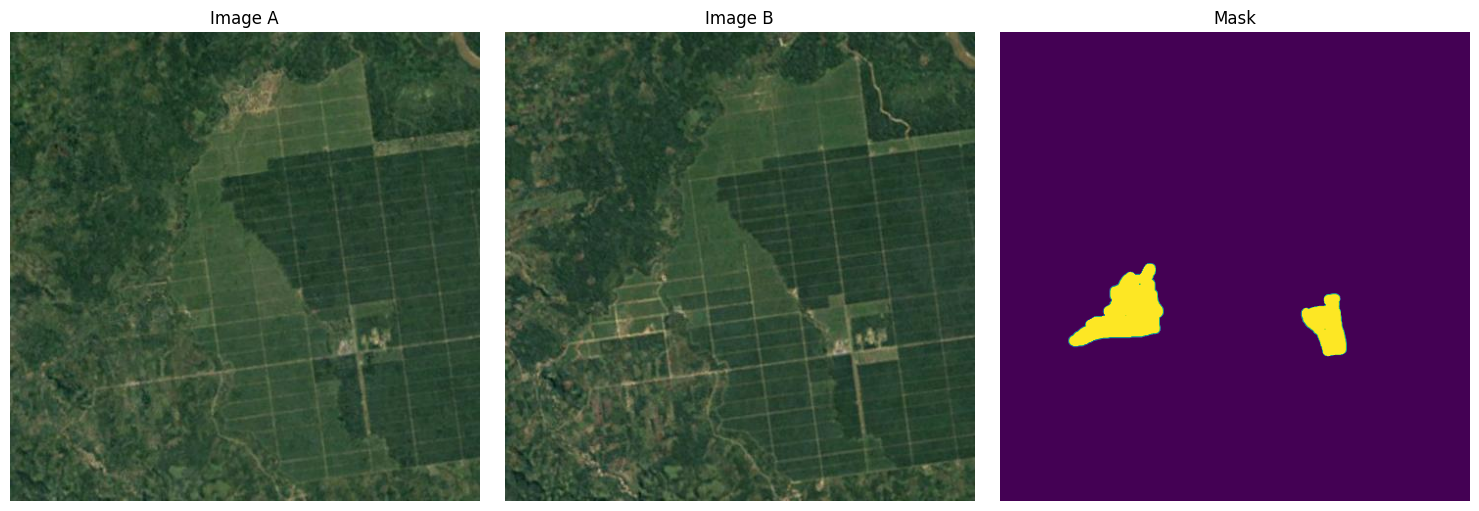

In [18]:
visualise_images_and_mask("train", 200)

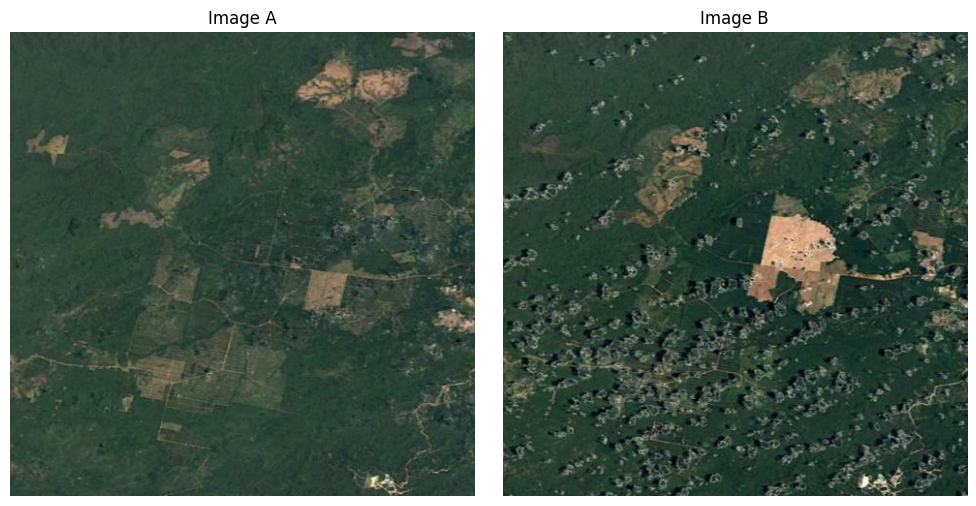

In [16]:
visualise_images("train", 8)

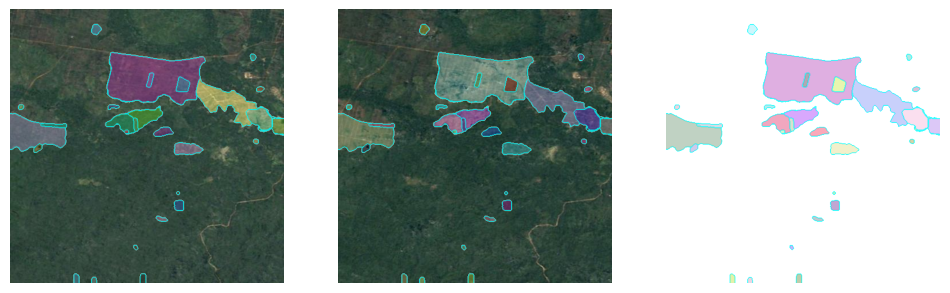

In [ ]:
from skimage.io import imread
from torchange.models.segment_any_change import AnyChange, show_change_masks
import cv2

def test_sac(split, file_num):
    file_id = f"{file_num + 0:06d}"
    imgA_path = os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'A', f'{split}_{file_id}.png')
    imgB_path = os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'B', f'{split}_{file_id}.png')

    imgA = imread(imgA_path)
    imgB = imread(imgB_path)

    m = AnyChange('vit_h', sam_checkpoint='./Multi_change/models_ckpt/sam_vit_h_4b8939.pth')
    m.make_mask_generator(
        points_per_side=32,
        stability_score_thresh=0.95,
    )

    m.set_hyperparameters(
        change_confidence_threshold=145,
        use_normalized_feature=True,
        bitemporal_match=True,
    )

    changemasks, _, _ = m.forward(imgA, imgB)
    fig, axes = show_change_masks(imgA, imgB, changemasks)

    plt.show()

test_sac("train", 249)


In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

class ImageStatsCalculator:
    """
    Loads ALL A and B images into one combined array for statistics calculation.
    Folder structure:
    dataset_root/
    └── images/
        ├── train/
        │   ├── A/
        │   └── B/
        ├── val/
        │   ├── A/
        │   └── B/
        └── test/
            ├── A/
            └── B/
    """
    
    def __init__(self, base_folder, img_size=(256, 256)):
        self.base_folder = base_folder
        self.img_size = img_size
        self.all_images = []  # Will store all loaded images
        self.all_labels = []
        self._load_images()

    def _load_images(self):
        # Find all splits (train/val/test)
        splits = [d for d in ["train", "val", "test"] 
                if os.path.isdir(os.path.join(self.base_folder, "images", d))]
        
        for split in splits:
            split_path = os.path.join(self.base_folder, "images", split)
            
            # Load all A images
            a_folder = os.path.join(split_path, "A")
            for img_file in tqdm(os.listdir(a_folder), desc=f"Loading {split}/A"):
                if img_file.startswith('.'): continue
                img = self._load_single_image(os.path.join(a_folder, img_file))
                self.all_images.append(img)
            
            # Load all B images 
            b_folder = os.path.join(split_path, "B")
            for img_file in tqdm(os.listdir(b_folder), desc=f"Loading {split}/B"):
                if img_file.startswith('.'): continue
                img = self._load_single_image(os.path.join(b_folder, img_file))
                self.all_images.append(img)

            label_folder = os.path.join(split_path, "label")
            for img_file in tqdm(os.listdir(label_folder), desc=f"Loading {split}/label"):
                if img_file.startswith("."): continue
                img = self._load_single_mask(os.path.join(label_folder, img_file))
                self.all_labels.append(img)


    def _load_single_image(self, path):
        """Load and preprocess single image"""
        img = Image.open(path).convert('RGB')
        img = img.resize(self.img_size)
        return np.array(img) / 255.0  # Normalize to [0,1]
    
    def _load_single_mask(self, path):
        """Load single grayscale mask and convert to binary (0=background, 1=foreground)"""
        mask = Image.open(path).convert('L')  # Force grayscale
        mask = np.array(mask)
        return (mask > 0).astype(np.uint8)  # Convert to binary

    def calculate_stats(self):
        """Calculate mean and std for all images (combined A+B)"""
        if not self.all_images:
            raise ValueError("No images loaded!")
            
        # Convert to single numpy array (N, H, W, 3)
        image_stack = np.stack(self.all_images)
        
        # Calculate stats
        mean = np.round(np.mean(image_stack, axis=(0, 1, 2)), 5)  # Mean per channel
        std = np.round(np.std(image_stack, axis=(0, 1, 2)), 5)   # Std per channel
        
        return mean, std
    
    def calculate_detailed_mask_stats(self):
        """Calculate comprehensive mask statistics including per-image distribution"""
        per_image_foreground = []
        per_image_background = []
        hist_bins = np.linspace(0, 100, 21)  # 5% bins for histogram
        
        for label in self.all_labels:
            binary_mask = (label != 0).astype(np.uint8)
            total_pixels = binary_mask.size
            fg_pixels = np.sum(binary_mask == 1)
            fg_percent = (fg_pixels / total_pixels) * 100
            
            per_image_foreground.append(fg_percent)
            per_image_background.append(100 - fg_percent)
        
        # Convert to numpy arrays for calculations
        fg_percents = np.array(per_image_foreground)
        bg_percents = np.array(per_image_background)
        
        # Calculate statistics
        stats = {
            'foreground': {
                'min': float(np.min(fg_percents)),
                'max': float(np.max(fg_percents)),
                'mean': float(np.mean(fg_percents)),
                'median': float(np.median(fg_percents)),
                'std': float(np.std(fg_percents)),
                'histogram': {
                    'bins': hist_bins.tolist(),
                    'counts': np.histogram(fg_percents, bins=hist_bins)[0].tolist()
                }
            },
            'background': {
                'min': float(np.min(bg_percents)),
                'max': float(np.max(bg_percents)),
                'mean': float(np.mean(bg_percents)),
                'median': float(np.median(bg_percents)),
                'std': float(np.std(bg_percents))
            },
            'aggregate': {
                'foreground_percent': float(np.mean(fg_percents)),
                'background_percent': float(np.mean(bg_percents)),
                'ratio': float(np.mean(bg_percents) / np.mean(fg_percents)) 
                        if np.mean(fg_percents) != 0 else float('inf')
            }
        }
        
        return stats

# Usage:
BASE_FOLDER = "./Multi_change/data/Forest-Change-dataset"
calculator = ImageStatsCalculator(BASE_FOLDER)


Loading test/label: 100%|██████████| 33/33 [00:00<00:00, 287.89it/s]


Mean (RGB): [0.2267  0.29982 0.22058]
Std (RGB): [0.0923  0.06658 0.05681]

Label Statistics:
Mean foreground %: 4.81
Median background %: 96.77


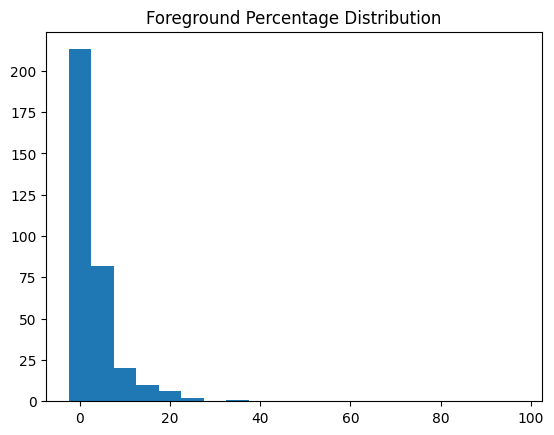

In [ ]:
mean, std = calculator.calculate_stats()

print(f"Mean (RGB): {mean}")
print(f"Std (RGB): {std}")


print("\nLabel Statistics:")
stats = calculator.calculate_detailed_mask_stats()

# Access individual metrics
print(f"Mean foreground %: {stats['foreground']['mean']:.2f}")
print(f"Mean background %: {stats['background']['mean']:.2f}")

# Plot histogram
import matplotlib.pyplot as plt
plt.bar(stats['foreground']['histogram']['bins'][:-1],
        stats['foreground']['histogram']['counts'],
        width=5)
plt.title("Foreground Percentage Distribution")
plt.show()
